In [2]:
def swap_clusters(nc,  rep_a, rep_b, var_to_replace="cluster",):
    # Extract the variable as a DataArray
    arr = nc[var_to_replace]

    # Step 1: Temporarily mark 0 as 100
    arr = xr.where(np.isfinite(arr) & (arr == rep_a), -1, arr)

    # Step 2: Replace 3 with 0
    arr = xr.where(np.isfinite(arr) & (arr == rep_b), rep_a, arr)

    # Step 3: Replace temporary 100 (originally 0) with -1
    arr = xr.where(np.isfinite(arr) & (arr == -1), rep_b, arr)

    # Return a new dataset with the updated variable
    return nc.assign({var_to_replace: arr})


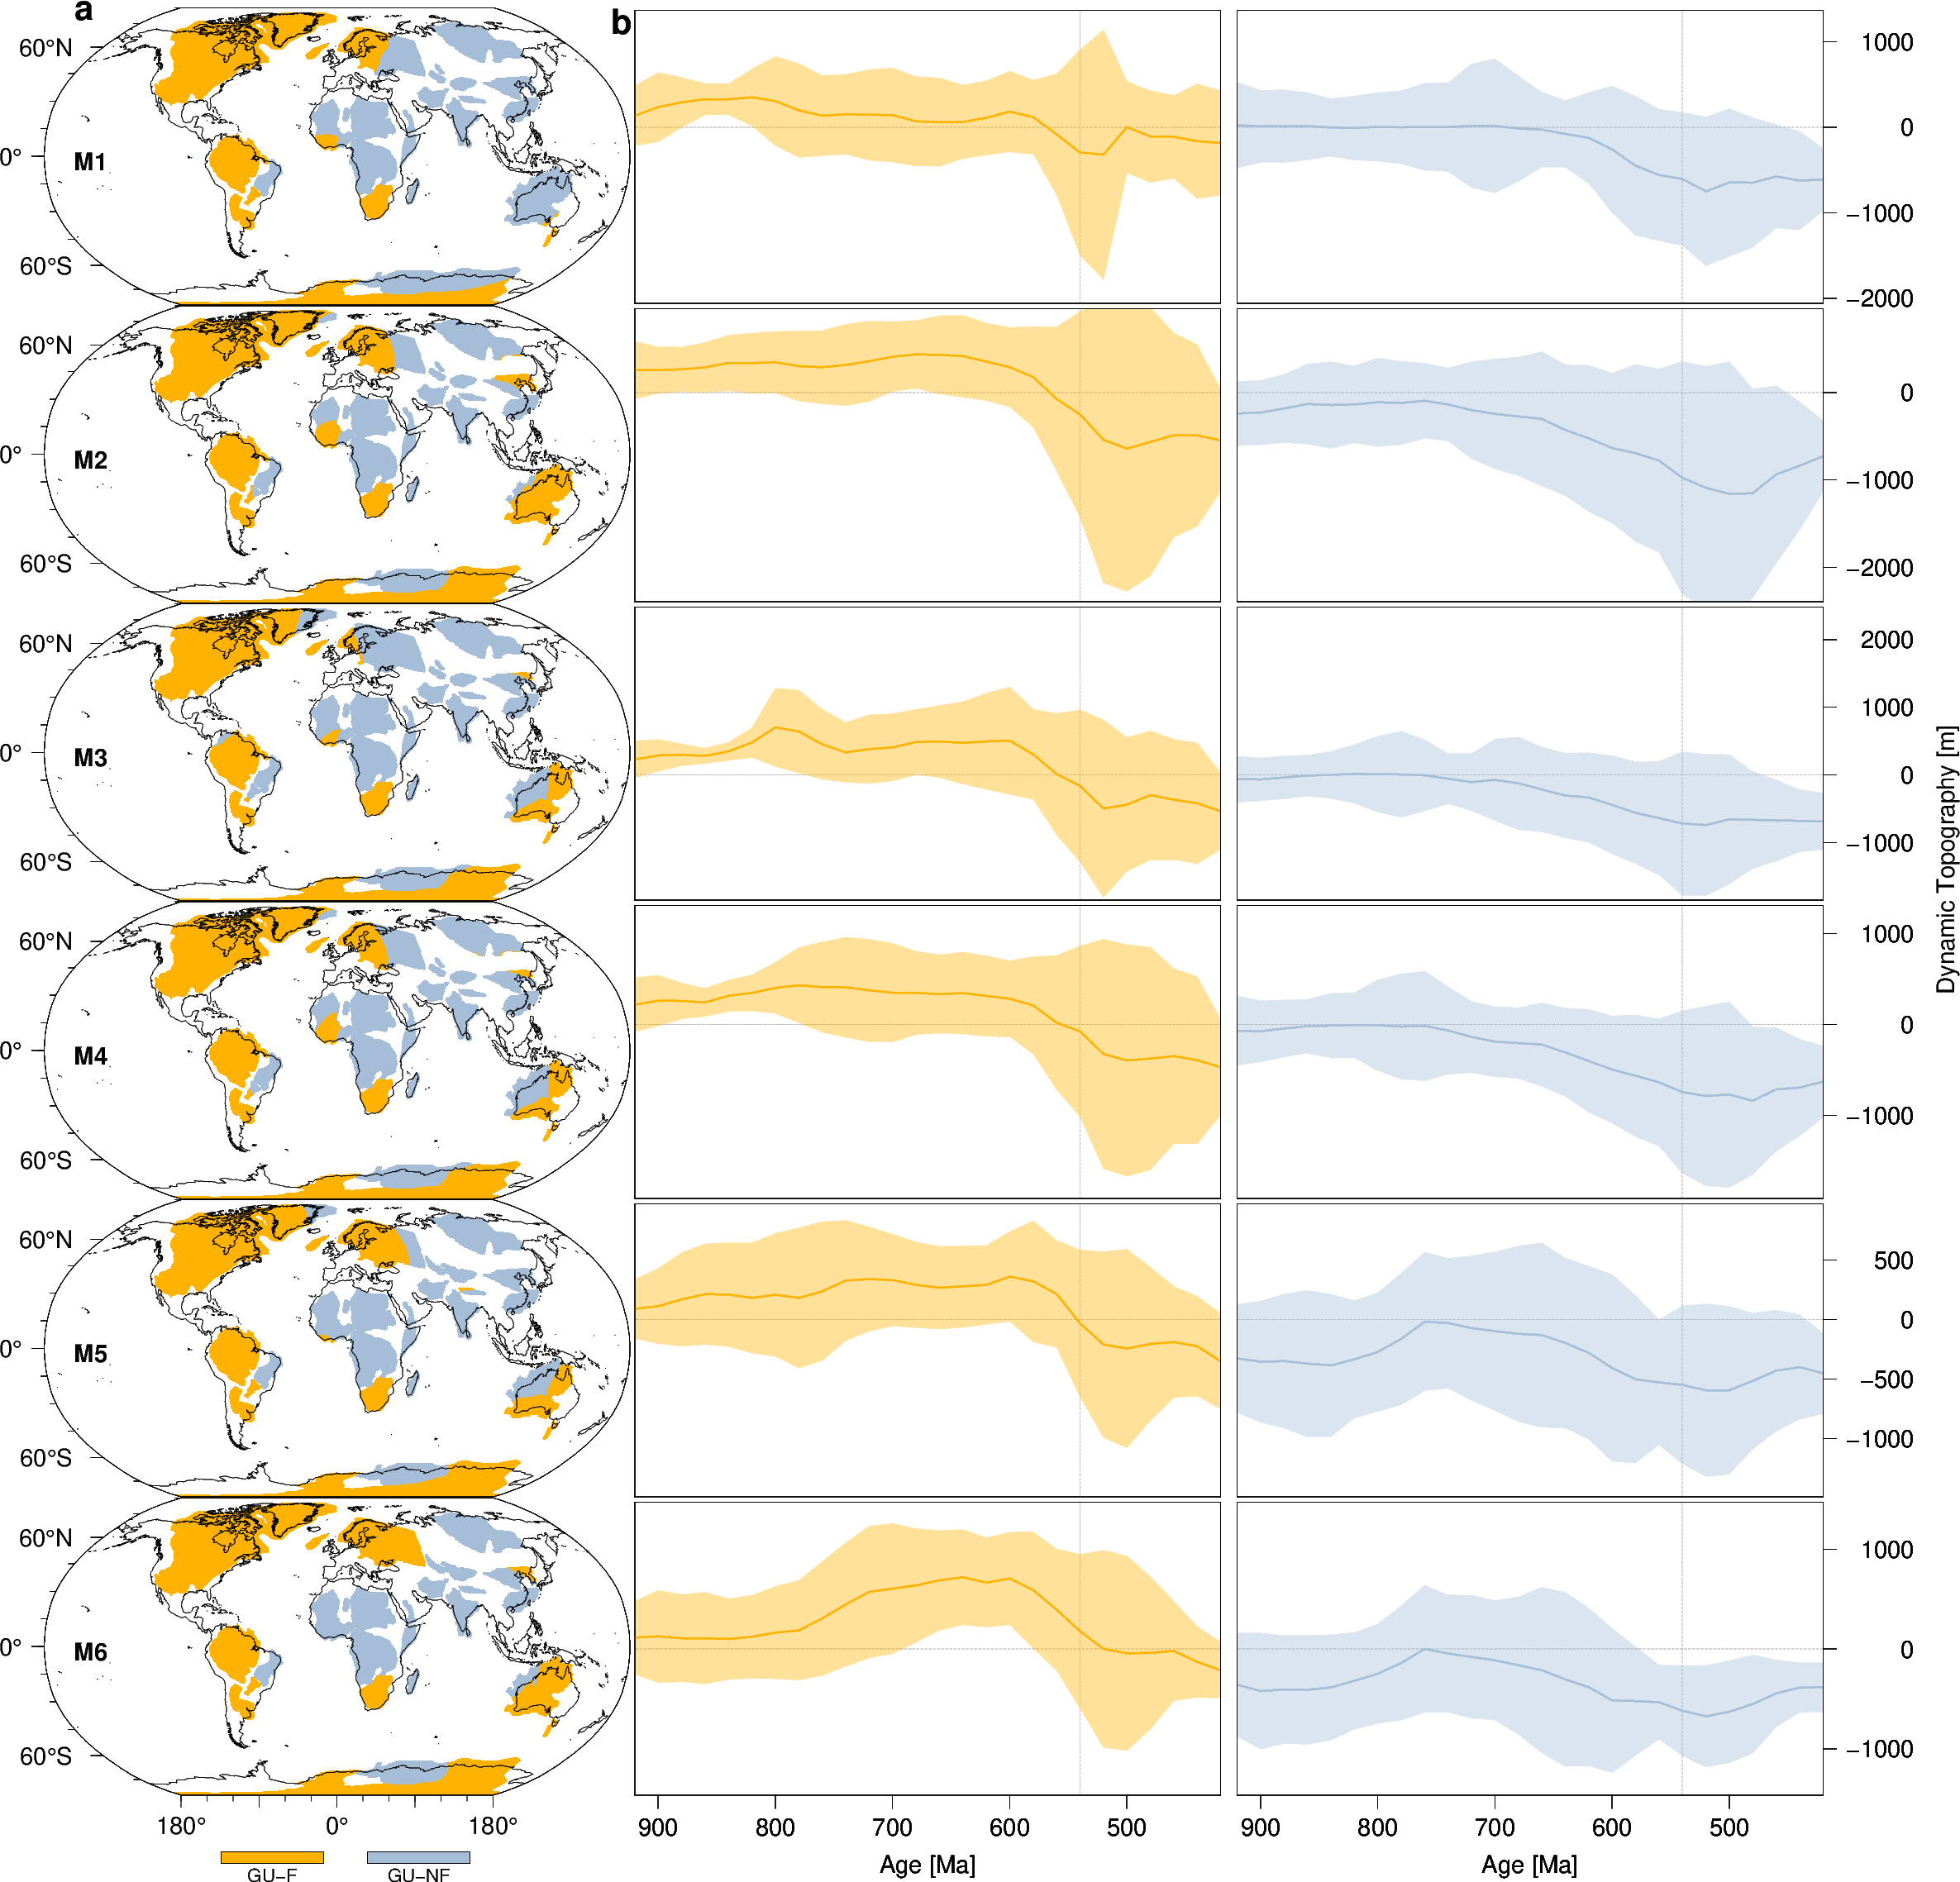

In [11]:
#pygmt all in one for spatio-temporal cluster analysis and elbow plot
import pygmt
import xarray as xr
import pandas as pd
import glob
import numpy as np

models = ['gld421', 'gld428', 'gld431', 'gld434','gld486', 'gld504',] #['gld428', 'gld504','gld560','gld563', 'gld564', 'gld565', ]

clusters_ =2
if clusters_==5:
    
    mapping ={
        'gld421' : {0:1, 1:3, 3:4},
        'gld428' : {0:1, 1:3, 2:4},
        'gld431' : {0:1, 1:3, 2:4, 3:4},
        'gld434' : {0:1, 1:3, 3:4},
        'gld486' : {0:4,0:1, 2:3 },
        'gld504' : {0:4,  },
        
    }
    
    series =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3,C4,C5"
    cmap ='gmt/cyclic'
    
elif clusters_==4:
    series =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3,C4"
    cmap ='gmt/cyclic'
    mapping ={
        'gld421' : {0:3},
        'gld428' : {0:3,},
        'gld431' : {0:1,  2:3, 1:3},
        'gld434' : {0:1, 1:2, 2:3},
        'gld486' : {0:1, 1:3 },
        'gld504' : {0:1, 1:2, 2:3 },
        
    }
    
elif clusters_==2:
    series =[0, clusters_ -1, 1]
    color_model= "+cGU-F,GU-NF"
    cmap ='#FFB300,#A6BDD7' #'gmt/cyclic'
    mapping ={
        'gld421' : {0:1},
        'gld428' : {0:1,},
        'gld431' : {0:1, },
        'gld434' : {0:1, },
        'gld486' : {0:1,  },
        'gld504' : {0:1,  },
        
    }
    
else:
    series =[0, clusters_ -1, 1]
    color_model= "+cC1,C2,C3"
    cmap='earth'
    mapping ={
        'gld421' : {0:1, 1:2},
        'gld428' : {0:1, 1:2},
        'gld431' : {0:1, 1:2},
        'gld434' : {0:1, 1:2},
        'gld486' : {0:1, 1:2,},
        'gld504' : {0:1, 1:2,},
        
    }
    


#figure
pygmt.config(GMT_VERBOSE='q')
fig = pygmt.Figure()

#figure panels
fig_width ="6c"
fig_height = "18c"
subplot_depth ="6c"
text_labels = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6'] #['a)','b)','c)','d)','e)','f)']
clearance=None

with fig.subplot(
    nrows=6,
    ncols=1,
    figsize=(fig_width, fig_height),
    sharey='l', 
    sharex='b',
    frame='lrbt', 
):
    for j, model in enumerate(models):
        cluster_fpath = f'ClusterAnalysis/cluster_{model}_420-920_2.nc'
        NA_nc_fpath = f'ClusterAnalysis/NA_{model}_420-920.nc'
        
        cluster = xr.open_dataset(cluster_fpath)

        if model in models:
            mapping_model =mapping[model]
            for rep_a, rep_b in mapping_model.items():
                cluster = swap_clusters(cluster, rep_a, rep_b)
        # for swap_a, swap_b in final_mapping.items():
        #     cluster = swap_clusters(cluster, swap_a, swap_b)      
        NA_Nc = xr.open_dataset(NA_nc_fpath)

        if j <3:
            clearance =['n0c']
            offset="0c/0.1c",
        else:
            clearance =['s0c']
            offset="0c/0.1c",
        
        projection ="N6c"
       
        #clearance =['n2c']
        with fig.set_panel(panel=[j],clearance=clearance):
            pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_TITLE="7p", FONT_HEADING ='7p', FONT_LABEL="7p", FONT_ANNOT="7p", FONT_ANNOT_PRIMARY="7p",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01')
            # plot cluster in frame c
            pygmt.makecpt(cmap=cmap, series=series, color_model= color_model)
            
            fig.grdimage(grid=cluster.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None, verbose='q')
            fig.coast(shorelines="1/0.1p", region='d', projection=projection)
            
    
            fig.text(
                text=f"{text_labels[int(j)]}",
                position="ML",  # Top Left
                font ='7p,Helvetica-Bold, black',
                justify="ML",  # Top Left
                offset=offset,
                no_clip=True
            )
        
        fig.basemap(region='d', projection=projection, frame= ['lrbt'])
        
fig.text(
            x=0.2,
            y=7.08, # position (adjust as needed)
            text="a",
            font="10p,Helvetica-Bold,black",    # font size, style, colo                  
            justify="CM", # center-middle alignment
            no_clip=True,
            offset ='-0.1/0.3'
        )
        
        # #shift origin for next plot
fig.shift_origin(xshift="w+0.05c")


with fig.subplot(
    nrows=6,
    ncols=2,
    figsize=(12, fig_height),
    sharex="b",  # shared x-axis on the bottom side
    sharey="r",
    frame='lrbt',
):
    text_labels= ['M1', 'M2', 'M3', 'M4', 'M5', 'M6'] #['g)','h)','i)','j)','k)','l)']
    
    for j, model  in enumerate(models):
        
        cluster_fpath = f'ClusterAnalysis/cluster_{model}_420-920_2.nc'
        NA_nc_fpath = f'ClusterAnalysis/NA_{model}_420-920.nc'
        
        cluster = xr.open_dataset(cluster_fpath)
       
        NA_Nc = xr.open_dataset(NA_nc_fpath)
        if model in models:
            mapping_model =mapping[model]
            for rep_a, rep_b in mapping_model.items():
                cluster = swap_clusters(cluster, rep_a, rep_b)

    
            # Convert cluster to a DataFrame safely
            df = (
                cluster.to_dataframe()
                .dropna()
                .reset_index()
                .drop(['lat', 'lon'], axis=1)
                .copy()  # ensures df is a copy, avoids SettingWithCopyWarning
            )
            
            # Compute aggregation statistics
            agg = (
                df.groupby(["cluster", "age"])
                  .agg(["mean", "std", "min", "max"])
                  .reset_index()
                  .droplevel(1, axis=1)
                .copy()
            )
            agg.columns = ["cluster", "age", "z", "std", "min", "max"]
            
            # Compute mean by cluster and age
            df = (
                df.groupby(["cluster", "age"])
                  .mean(numeric_only=True)
                  .reset_index()
                  .copy()
            )
            
            # Mean over lat/lon for NA_Nc
            df_NA = NA_Nc.mean(dim=["lat", "lon"]).to_dataframe().reset_index().copy()
            
            # Aggregation for NA_Nc
            df_NA_agg = (
                NA_Nc.to_dataframe()
                .dropna()
                .reset_index()
                .drop(["lat", "lon"], axis=1)
                .copy()  # make a copy to avoid chained assignment issues
            )
            
            df_NA_agg = (
                df_NA_agg.groupby(["age"])
                  .agg(["mean", "std"])
                  .reset_index()
                  .droplevel(1, axis=1)
            )
            df_NA_agg.columns = ["age", "z", "std"]
            
            # Safely add derived columns
            df_NA_agg["upper_std"] = df_NA_agg["z"] + 2 * df_NA_agg["std"]
            df_NA_agg["lower_std"] = df_NA_agg["z"] - 2 * df_NA_agg["std"]

            region_cl = [420,920, agg['min'].min()*1.2, agg['max'].max()*1.1,]
            #print(df_NA_agg.head())
            proj_cl ="X-6c/3c"

            if j==len(models)-1:
                frame_j =['Strl', 'xa200+lAge [Ma]']
            else:
                frame_j =['lrbt']

            for i in np.unique(df.cluster):
                if i==1 and j==len(models)-1 :
                    frame =['StEl', 'ya', 'xa100+lAge [Ma]']
                elif i==1:
                    frame =['Etbl', 'ya']
                
                elif j==len(models)-1:
                    frame =['Strl', 'xa100+lAge [Ma]', ]
                
                
                else:
                    frame =['rtlb']
        
                with fig.set_panel(panel=[j,i],clearance=clearance):
                    pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_TITLE="7p, Helvetica", FONT_HEADING ='7p, Helvetica', FONT_LABEL="7p, Helvetica", FONT_ANNOT="7p, Helvetica", FONT_ANNOT_PRIMARY="7p, Helvetica",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01')

                    #prepare dataset
                    df_selected = df[df.cluster==i].copy()
                    #agg_selected = agg[agg.cluster==i]
                    agg_selected = agg[agg['cluster'] == i].copy()

                    agg_selected['upper_std'] = agg_selected['z'] + 2*agg_selected['std']
                    agg_selected['lower_std'] = agg_selected['z'] - 2*agg_selected['std']
                    xs = pd.concat([agg_selected["age"], agg_selected["age"][::-1]]).to_numpy()
                    ys = pd.concat([agg_selected["min"], agg_selected["max"][::-1]]).to_numpy()
                    ys_na = pd.concat([df_NA_agg["lower_std"], df_NA_agg["upper_std"][::-1]]).to_numpy()
                    ys_std = pd.concat([agg_selected["lower_std"], agg_selected["upper_std"][::-1]]).to_numpy()

                    #Plotting
                    pygmt.makecpt(cmap=cmap, series=series, color_model= color_model)
                    fig.basemap(region=region_cl, projection=proj_cl, frame= frame)  
                    fig.plot(x=[540]*len(df_NA.z), y=np.linspace(agg_selected['min'].min()*3, agg_selected['max'].max()*3, len(df_NA.z)), region=region_cl, projection = proj_cl, pen='0.1p,grey, --')
                    fig.plot(x=df_NA.age, y=[0]*df_NA.z, region=region_cl, projection = proj_cl, pen='0.1p,grey, --')
                    fig.plot(x=xs, y=ys_std, region=region_cl, projection = proj_cl,zvalue=i, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                    fig.plot(x=df_selected.age, y=df_selected.z, region=region_cl, projection = proj_cl,zvalue=i, pen='0.5p,+z', cmap=True, frame=frame, )
                    #fig.plot(x=agg_selected.age, y=agg_selected.upper_std, region=region_cl, projection = proj_cl,zvalue=i, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                    #fig.plot(x=xs, y=ys, region=region_cl, projection = proj_cl,zvalue=i, fill='+z', cmap=True, frame=['lbrt'], transparency=60 )
                    
                    
                    if j== len(models)-1:
                        label ='Laurentia'
                    else:
                        label=None

            
    fig.text(
            x=12.5, y=25,                      # position (adjust as needed)
            text="Dynamic Topography [m]",
            font="7p,Helvetica, black",    # font size, style, color
            angle=90,                          # rotate to vertical
            justify="CM", # center-middle alignment
            no_clip=True
        )
    fig.text(
        x=-23,
        y=46.6, # position (adjust as needed)
        text="b",
        font="10p,Helvetica-Bold,black",    # font size, style, colo                  
        justify="CM", # center-middle alignment
        no_clip=True,
        offset ='0.05/0.3'
    )
    
       #fig.colorbar(cmap=True, position="x-3c/8.95c+w4c/0.5c+jTC+h+e+ml")
    with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
        fig.colorbar(cmap=True, position="JMR+o-14c/-2c+w3c+h")
    fig.savefig(f'./ExtendedDataFigures/EDF3_DTevolution_{clusters_}clusters_20Ma_errorbar-2SD.png', dpi=600, resize='+s18.2c' )
        
fig.show()